In [2]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 16, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

### Example graph 

57


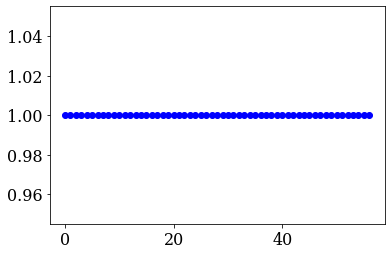

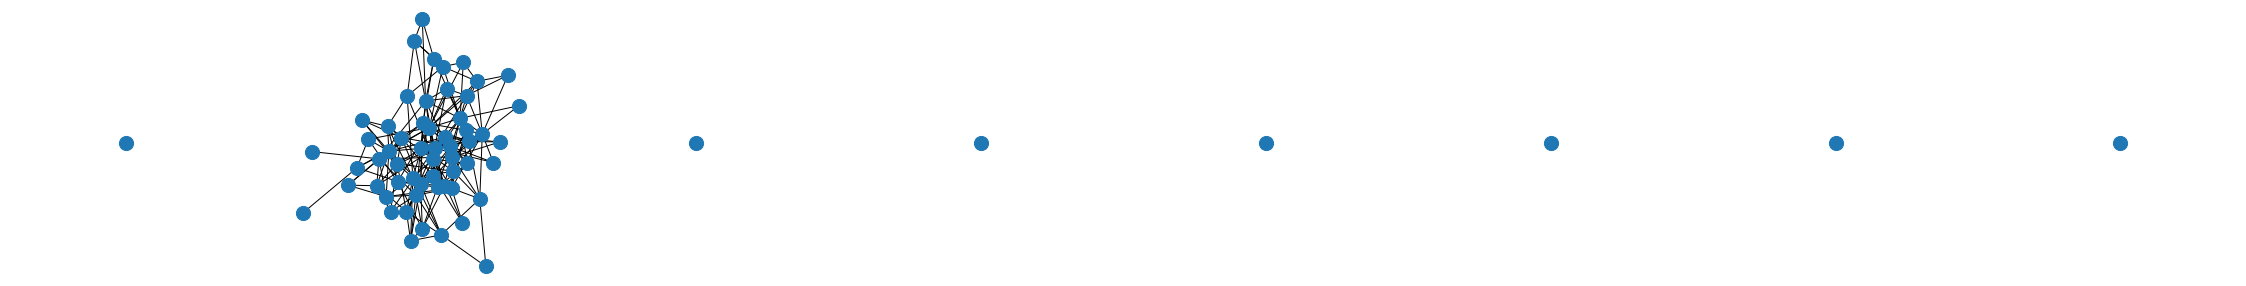

In [2]:
n=64
c=0.5
nr=int(c*n)
seed=1

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr)
adj=np.zeros((n,n))
for r in range(2*nr):
    reac=np.where(eta[r]>0)[0]
    prod=np.where(nu[r]>0)[0]
    for i in reac:
        for j in prod:
            adj[i,j]=1
        #if species are both reactants, they affect rates of change of each other
        for j in reac:
            adj[i,j]=1
g=nx.convert_matrix.from_numpy_matrix(adj)

lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

print(n)
X0=np.exp(-G)
XD1=np.zeros(n)
XD2=np.zeros(n)
success,Xs2=rmtchem.steady(X0,eta,nu,k,XD1,XD2)
plt.plot(Xs2/X0,'bo')
plt.show()

g=nx.convert_matrix.from_numpy_matrix(adj)
components=list(sorted(nx.connected_components(g)))
if len(components)>1:
    fig, ax = plt.subplots(1,len(components),figsize=(5*len(components),5))
    for i in range(len(components)):
        comp=list(components)[i]
        idx=np.array(list(comp))
        nx.draw(nx.convert_matrix.from_numpy_matrix(adj[np.ix_(idx,idx)]),node_size=200,ax=ax[i])
        ax[i].axis('off')
else:
    nx.draw(g,node_size=200)

plt.savefig('plots/fig1b.pdf')
plt.show()
# Xs,success=rmtchem.integrate(X0,eta,nu,k,XD1,XD2,100,0.1,prog=True)
# plt.plot(Xs)
# plt.show()

### Chemical network percolation

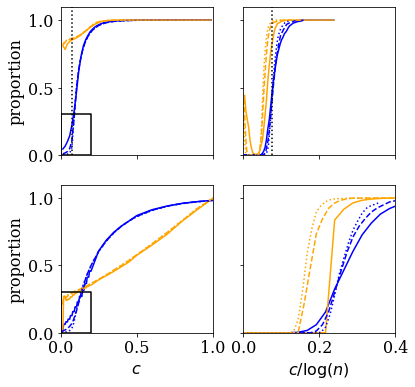

In [202]:
ns=[64,512,4096]
ls=['-','--',':']

plt.subplots(2,2,figsize=(6,6))

plt.subplot(2,2,1)
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
locs, labels = plt.xticks()
plt.xticks(locs,[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3),dat[:,3],color='orange',linestyle=ls[i])
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,2)
plt.ylim(0,1.1)
plt.xlim(0,0.4)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

locs, labels = plt.xticks()
plt.xticks(locs,[])
for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/(20/3)/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(2,2,3)
plt.xlabel('$c$')
plt.ylabel("proportion")
plt.ylim(0,1.1)
plt.xlim(0,1)
for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1],dat[:,3],color='orange',linestyle=ls[i])
    
plt.plot([0,0.2,0.2,0,0],[0.3,0.3,0,0,0.3],color='black')

plt.subplot(2,2,4)
plt.xlabel('$c/\log(n)$')
plt.xlim(0,0.4)
plt.ylim(0,1.1)
locs, labels = plt.yticks()
plt.yticks(locs,[])
plt.ylim(0,1.1)

for i in range(len(ns)):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/np.log(n),dat[:,4],color='blue',linestyle=ls[i])
    plt.plot(dat[:,1]/np.log(n),dat[:,5],color='orange',linestyle=ls[i])
plt.savefig('plots/fig2.pdf')
plt.show()

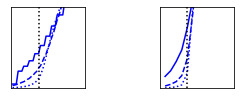

In [5]:
ns=[64,512,4096]
ls=['-','--',':']
fig, axs = plt.subplots(1,2,figsize=(4,1.5))

plt.subplot(1,2,1)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/sing/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1],dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')

plt.subplot(1,2,2)
plt.xlim(0,0.2)
plt.ylim(0,0.3)
plt.yticks([],[])
plt.xticks([],[])

for i in range(3):
    n=ns[i]
    dat=np.loadtxt('data/er/'+str(n)+'_counts.txt')
    plt.plot(dat[:,1]/(20/3),dat[:,2],color='blue',linestyle=ls[i])
plt.plot([3/40,3/40],[0,1.1],color='black',linestyle=':')
plt.subplots_adjust(wspace=1.0,hspace=0.0)

plt.savefig('plots/fig2insets.pdf')
plt.show()


### Bifurcation examples

0.0352	
Changed branches! decreasing step 3.5100 	0.0100	83.4186	45.2025
0.0439	
Changed branches! decreasing step 4.3900 	0.0050	54.2938	39.6350
0.0439	
Changed branches! decreasing step 4.3925 	0.0025	13.7019	7.4499
0.0775	
Branch lost! decreasing step 7.7437 0.0050	
0.0913	
Branch lost! decreasing step 9.1213 0.0050	
0.0930	
Branch lost! decreasing step 9.2988 0.0050	
0.0938	
Branch lost! decreasing step 9.3738 0.0050	
0.0939	
Branch lost! decreasing step 9.3863 0.0025	
0.0963	
Branch lost! decreasing step 9.6263 0.0050	
0.0979	
Branch lost! decreasing step 9.7813 0.0050	
0.1008	
Branch lost! decreasing step 10.0738 0.0050	
0.1030	
Branch lost! decreasing step 10.2913 0.0050	
0.1030	
Branch lost! decreasing step 10.2938 0.0025	
0.1035	
Branch lost! decreasing step 10.3475 0.0050	
0.1048	
Branch lost! decreasing step 10.4775 0.0050	
0.1048	
Branch lost! decreasing step 10.4800 0.0025	
0.1061	
Branch lost! decreasing step 10.6075 0.0050	
0.1067	
Branch lost! decreasing step 10.6600 0.

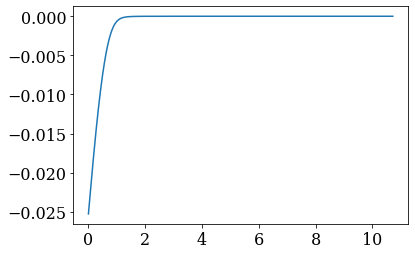

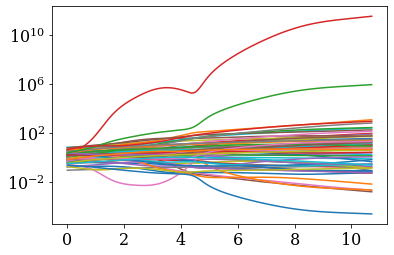

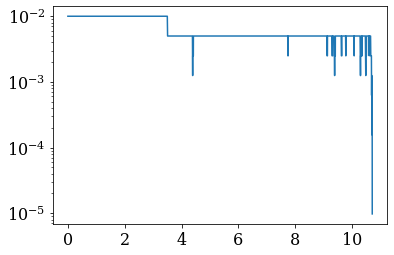

In [640]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=995
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,steps,True, False)

plt.plot(epsilons,np.max(np.real(evals),axis=1))
plt.show()
plt.yscale('log')
plt.plot(epsilons,Xs)
plt.show()

plt.yscale('log')
plt.plot(epsilons[:-1],np.diff(epsilons))
plt.show()

10.714384765625221 10.71409570312522


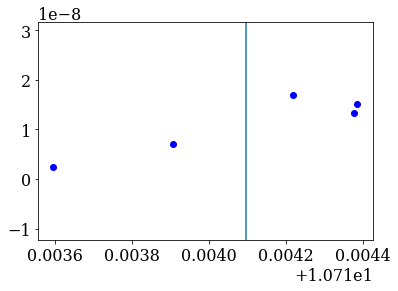

0.0006815818608260462


In [641]:
SNnum=5
ys=np.linalg.norm(Xs[-SNnum:]/Xs[-1],axis=1)
ys=np.min(np.abs(evals[-SNnum:]),axis=1)
xs=epsilons[-SNnum:]
# a=(ys[-1]-ys[0])/(xs[-1]-xs[0])
b=0.5*(ys[-1]+ys[0]-a*(xs[-1]+xs[0]))
sol=leastsq(lambda x: x[0]+x[1]*ys**2-xs,[b,0])
print(epsilons[-1],sol[0][0])
# print(epsilons[-1],sol[0][0]-sol[0][1]**2/(4*sol[0][2]),-sol[0][1]/(2*sol[0][2]))
plt.plot(xs,ys,'bo')
v1=np.min(ys)
v2=np.max(ys)
plt.ylim(v1-(v2-v1),v2+(v2-v1))
vals=np.arange(v1-(v2-v1),v2+(v2-v1),(v2-v1)/100)
plt.plot(sol[0][0]+sol[0][1]*vals**2,vals)
# plt.plot(sol[0][0]+sol[0][1]*vals+sol[0][2]*vals**2,vals)
plt.show()
fn=np.linalg.norm(sol[0][0]+sol[0][1]*ys**2-xs)
print(fn)


In [639]:
print((xs-sol[0][0]))

[-0.0065  -0.0015   0.001    0.00225  0.00475]


12.967519531250344 12.948740115504037 3.9443284283521938


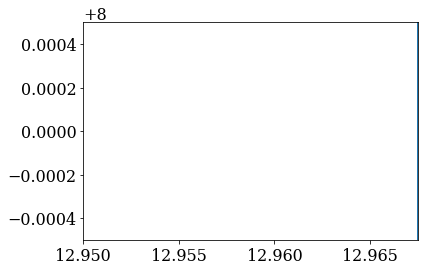

In [516]:
SNnum=10
a=(np.linalg.norm(sols[-1]/sols[-1])-np.linalg.norm(sols[-SNnum]/sols[-1]))/(epsilons[-1]-epsilons[-SNnum])
b=0.5*((np.linalg.norm(sols[-1]/sols[-1])+np.linalg.norm(sols[-SNnum]/sols[-1]) )-a*(epsilons[-1]+epsilons[-SNnum]))
sol=leastsq(lambda x: x[0]+x[1]*np.linalg.norm(sols[-SNnum:]/sols[-1],axis=1) +x[2]*np.linalg.norm(sols[-SNnum:]/sols[-1],axis=1)**2-epsilons[-SNnum:],[b,a,0])
print(epsilons[-1],sol[0][0]-sol[0][1]**2/(4*sol[0][2]),-sol[0][1]/(2*sol[0][2]))
vals=2*(-sol[0][1]/(2*sol[0][2]))*np.arange(10000)/10000
plt.plot(epsilons[-SNnum:],np.linalg.norm(Xs[-SNnum:]/Xs[-1],axis=1) )
plt.plot(sol[0][0]+sol[0][1]*vals+sol[0][2]*vals**2,vals)
plt.xlim(epsilons[-SNnum],epsilons[-1])
plt.ylim(7.9995,8.0005)
plt.show()


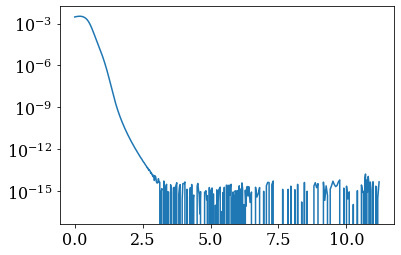

In [70]:
plt.yscale('log')
plt.plot(epsilons,-np.max(np.real(evals),axis=1))
plt.show()

In [11]:
imp.reload(rmtchem)
n=16
nr=int(0.4*n*np.log(n))
nd=int(0.1*n)
na=0
seed=37
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e3
d1min=0
d1max=100
steps=1000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,steps,True, False)
stop=timeit.default_timer()
print(stop-start)
plt.plot(np.max(np.real(evals[:-2]),axis=1))
plt.show()

plt.plot(Xs)
plt.yscale('log')
plt.show()
# X2s,evals2,bif2=rmtchem.quasistatic(sol.x, eta, nu, k, np.flip(XD1s[:m+2],axis=0), np.flip(XD2s[:m+2],axis=0), True)
# X3s,evals3,bif3=rmtchem.quasistatic(X2s[0], eta, nu, k, XD1s[m+1:], XD2s[m+1:], True)

0.006307143999947584


AxisError: axis 1 is out of bounds for array of dimension 1

False


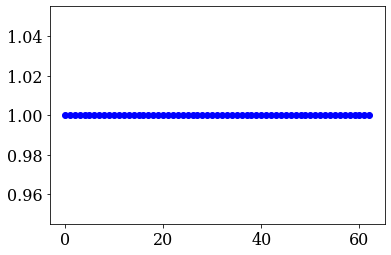

4.487859476134068e-08


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))


False



/Users/zack/Documents/rmtchem/rmtchem.py:66: RuntimeWarning: divide by zero encountered in true_divide
  return -np.diag(XD2)+np.transpose((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis]).dot(nu/X)
/Users/zack/Documents/rmtchem/rmtchem.py:66: RuntimeWarning: invalid value encountered in true_divide
  return -np.diag(XD2)+np.transpose((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis]).dot(nu/X)
/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


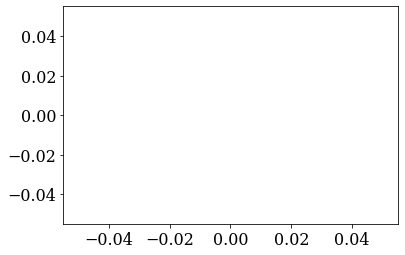

/Users/zack/Documents/rmtchem/rmtchem.py:66: RuntimeWarning: divide by zero encountered in true_divide
  return -np.diag(XD2)+np.transpose((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis]).dot(nu/X)
/Users/zack/Documents/rmtchem/rmtchem.py:66: RuntimeWarning: invalid value encountered in true_divide
  return -np.diag(XD2)+np.transpose((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis]).dot(nu/X)


LinAlgError: Array must not contain infs or NaNs

In [136]:
imp.reload(rmtchem)

m=len(Xs)-1
XD1=XD1s[m+100]
XD2=XD2s[m+100]
np.random.seed(3)
success,solx=rmtchem.steady(Xs[m],eta, nu, k, XD1,XD2)
print(success)
plt.plot(Xs[m]/(solx),'bo')
plt.show()

mat=rmtchem.jac(0,Xs[m],eta, nu, k, XD1,XD2)
ev,evec=np.linalg.eig(mat)
print(np.max(np.real(ev)))

X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*1e-2), eta, nu, k, XD1,XD2,1e7,1e3,prog=True)

success,solx=rmtchem.steady(X2[-1],eta, nu, k, XD1,XD2)
print(success)
plt.plot(Xs[m]/(solx),'bo')
plt.show()

mat=rmtchem.jac(0,solx,eta, nu, k, XD1,XD2)
ev,evec=np.linalg.eig(mat)
print(np.max(np.real(ev)))

plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

In [151]:
if(success):
    X2s,evals2,bif2=rmtchem.quasistatic(solx, eta, nu, k, np.flip(XD1s[:m+11],axis=0), np.flip(XD2s[:m+11],axis=0), True)
    X3s,evals3,bif3=rmtchem.quasistatic(X2s[0], eta, nu, k, XD1s[m+10:], XD2s[m+10:], True)

True
False

saddle-node bifurcation!  1
True
False

saddle-node bifurcation!  1


ValueError: could not broadcast input array from shape (19) into shape (3253)

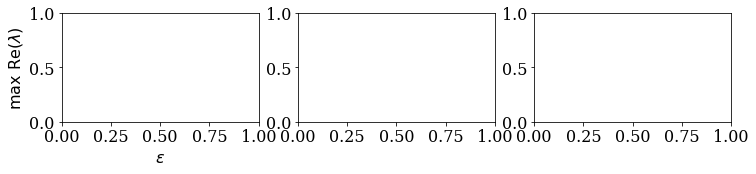

In [565]:
m=len(Xs)-1
m2=len(X2s)-1
plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
evals4=np.zeros(steps)
evals5=np.zeros(steps)
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
evals4[:m+1]=np.max(np.real(evals),axis=1)
evals4[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m+1:]=np.max(np.real(evals3),axis=1)
evals5[m-m2:m+1]=np.flip(np.max(np.real(evals2),axis=1),axis=0)
evals5[:m-m2]=np.max(np.real(evals),axis=1)[:m-m2]
plt.plot(d1s,evals4)
plt.plot(d1s,evals5)

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[-1,np.argsort(np.real(evals[-1]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[-2]),np.imag(evals[-2]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel(r"$X_i'/X_i^0$")
plt.xlabel('$\epsilon$')
X4s=np.zeros((steps,n))
X5s=np.zeros((steps,n))
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)
X4s[:m+1]=Xs
X4s[m+1:]=X3s
X5s[m+1:]=X3s
X5s[m-m2:m+1]=np.flip(X2s,axis=0)
X5s[:m-m2]=Xs[:m-m2]
plt.yscale('log')
plt.ylim(0.01,100)
plt.plot(d1s,X5s/X4s)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3a.pdf')
plt.show()

In [ ]:
#TODO: do this for the saddle-node bifurcations, and pick one that occurs for intermediate m

6.360152171639691
6.6179311206640525
6.888810500795899
7.173375043182967
7.472226508759369
7.785983627657595
8.115282011505302
8.460774041848916
8.823128739885176
9.203031622775649
9.601184551394361
10.018305576915317
10.455128792811259
10.912404197965065
11.390897580578997
11.891390427868966
12.414679870885132
12.961578670438287
13.532915252521606
14.129533798651158
14.752294398128168
15.402073267926347
16.079763044430305
16.786273150909462
17.522530245002496
18.289478745519272
19.088081444123333
19.919320195512228
20.784196690259105
21.683733306660933
22.618974035963475
23.590985481114622
24.600857920638678
25.6497064337875
26.73867208070857
27.868923130873227
29.04165633450963
30.25809822288479
31.519506443822234
32.82717110778612
34.18241615311682
35.586600711460505
37.041120473167574
38.54740904635498
40.10693929170111
41.721224647857625
43.39182042113037
45.1203250427081
46.908381291394704
48.75767747303226
50.669948555233546
52.64697723658446
54.690594985913
56.802683002367495
5

4237.230091660449
4268.287427560398
4299.668761980929
4331.3695134400305
4363.394464494167
4395.737811250671
4428.397533272391
4461.38369593828
4494.681079531041
4528.300789043357
4562.235749232755
4596.487192878629
4631.0548511950965
4665.938284251914
4701.140081492778
4736.651702906005
4772.478877317943
4808.6202136405345
4845.07355864977
4881.844034235082
4918.924477179015
4956.31901488963
4994.022770364269
5032.042465312248
5070.368624405699
5109.010905366761
5147.965017511428
5187.224810827843
5226.797738603404
5266.685830948042
5306.877918848798
5347.385710262624
5388.202130798791
5429.324150889641
5470.764135858899
5512.509380171027
5554.569217710075
5596.932821116744
5639.614916129626
5682.594305664338
5725.899203824177
5769.50221113713
5813.42324152571
5857.651797849244
5902.187691619297
5947.040297178087
5992.199256827807
6037.672873915607
6083.454182544559
6129.545213264714
6175.94777252579
6222.661593170406
6269.689178627202
6317.027988788358
6364.674947873857
6412.64071415

54340.23659370268
54558.51316458635
54777.47464373462
54997.17018855598
55217.54946275148
55438.54199524114
55660.27994281043
55882.697188067315
56105.740045931096
56329.485471230975
56553.854158466434
56779.02845086362
57004.816467357276
57231.23488624754
57458.40267491747
57686.25336296542
57914.810620682954
58143.96748845343
58373.853614058695
58604.46654149595
58835.687324641316
59067.66037877296
59300.31196764528
59533.66103891528
59767.523679302576
60002.47882455403
60237.703081567626
60473.76207364039
60710.60085618163
60948.053514505744
61186.217567763444
61425.10894264338
61664.58102240479
61904.88190403679
62145.80913454857
62387.42302467775
62629.75727213717
62872.77759282745
63116.513283416185
63360.81606153174
63606.065359757275
63851.81468314827
64098.38077763864
64345.5213373928
64593.492808340234
64842.013092598565
65091.44646839443
65341.383390286435
65592.22092502104
65843.52119952619
66095.66812793544
66348.58176909221
66601.97355848714
66856.36102780746
67111.220911

231645.05395097885
232237.1607116779
232834.11338676253
233429.45160875632
234026.80452266798
234622.98948593184
235224.27765894623
235821.9590791249
236424.3750125122
237024.78757700225
237629.77954582172
238231.42298144128
238837.34881147603
239443.87405769608
240050.92549565315
240656.98609138597
241264.8673043167
241878.85561103094
242487.0742157675
243098.5723944942
243709.56404153127
244327.5808932163
244941.22096238006
245556.37354992545
246173.1208140216
246790.27433680848
247411.23760530926
248029.83127429735
248650.65504716244
249272.7057190298
249895.1982489045
250518.0279790812
251141.6582774232
251771.15859489993
252399.04183389232
253022.947351305
253651.90508505836
254281.75405647763
254914.15690406796
255545.37354365448
256177.47548920425
256810.90315600362
257446.7062533058
258082.05796831258
258719.80300823195
259357.1655336033
259995.62914031936
260636.85163804694
261275.33936212407
261919.86852884898
262560.5147930383
263204.3944221901
263851.04244792456
264495.2728

592829.8625907757
593791.6840034133
594702.7855510222
595647.2196846927
596586.0042778121
597525.423600043
598444.825962464
599413.4477537146
600324.6153323979
601251.0251664297
602218.3392324318
603134.5154971441
604072.642887868
605022.8261920781
605941.292922979
606902.455867471
607812.4561664268
608767.0662423024
609688.8803826057
610647.2312326923
611568.1598845787
612500.6079169422
613445.8681710671
614380.3645925455
615311.0426161793
616261.7988600325
617190.2076314865
618126.9368408544
619065.0502754293
619993.1768371656
620936.1862540899
621868.8262654213
622817.9997667104
623746.2284324699
624675.9786323513
625620.5319333238
626556.2685559073
627488.4993103949
628410.6975267669
629366.8845360993
630298.4686427756
631221.655911236
1985 2


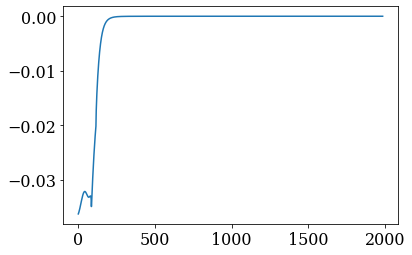

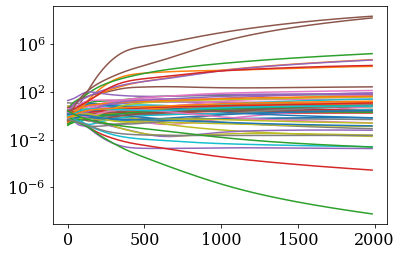

In [262]:
imp.reload(rmtchem)
n=64
nr=79
nd=6
na=0
seed=992
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na)

row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

d0=1e3
d1min=0
d1max=100
steps=5000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
Xs,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2,d1min,d1max, steps, output=False,stop=False)
print(len(Xs),bif)
plt.plot(np.max(np.real(evals),axis=1))
plt.show()

plt.plot(Xs)
plt.yscale('log')
plt.show()

Integration: 100%|##############################################| Time: 0:00:02


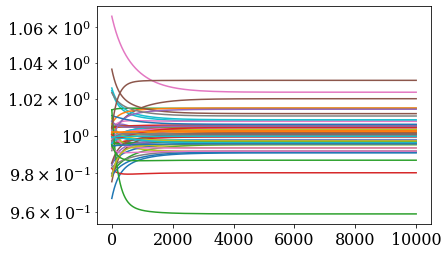

In [153]:
# m=np.where(np.max(np.real(evals),axis=1)>1e-2)[0][0]
m=len(Xs)-1
XD1=XD1s[m+10]
XD2=XD2s[m+10]
X2,success=rmtchem.integrate(Xs[m]*(1+(0.5-np.random.random(size=n))*1e-2), eta, nu, k, XD1,XD2,1e8,1e4,prog=True)
plt.yscale('log')
plt.plot(X2/Xs[m])
plt.show()

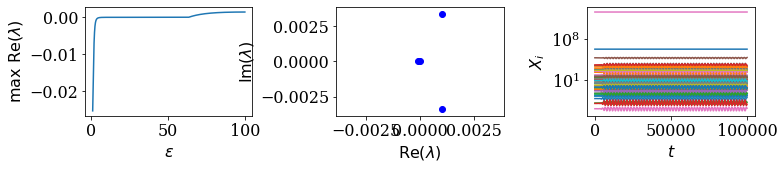

In [99]:
d1s=np.arange(d1min,d1max,(d1max-d1min)/steps)

plt.subplots(1,3,figsize=(12,2))
plt.subplot(1,3,1)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\mathrm{max}~\mathrm{Re}(\lambda)$')
plt.plot(d1s,np.max(np.real(evals),axis=1))

plt.subplot(1,3,2)
lim=1.1*np.max(np.abs(evals[m,np.argsort(np.real(evals[m]))[-3:]]))
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
# plt.ylim(-0.1,0.1)
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.plot(np.real(evals[m]),np.imag(evals[m]),'bo')

plt.subplot(1,3,3)
plt.yscale('log')
plt.ylabel('$X_i$')
plt.xlabel('$t$')
plt.plot(np.arange(0,1e5,1e1),X2)
plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3b.pdf')
plt.show()

### Bifurcations vs driving and connectivity

(81, 5)


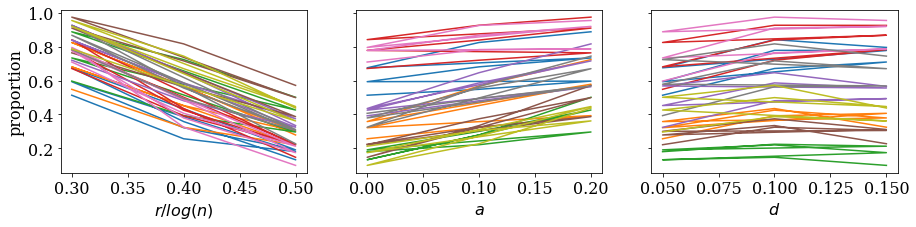

In [7]:
ns=[64,128,256]
cs=[0.3,0.4,0.5]
ds=[0.05,0.1,0.15]
ass=[0,0.1,0.2]
tab=[]
for n in ns:
    for c in cs:
        for d in ds:
            for a in ass:
                vals=np.loadtxt('data/hystereses2/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                tot=np.count_nonzero(vals[:,4]==0)+np.count_nonzero(vals[:,4]==1)+np.count_nonzero(vals[:,4]==2)
                tab.append([c, d, a, np.count_nonzero(vals[:,4]==1)/tot,  np.count_nonzero(vals[:,4]==2)/tot])
                
tab=np.array(tab)
print(tab.shape)
cs=np.unique(tab[:,0])
ds=np.unique(tab[:,1])
ass=np.unique(tab[:,2])

fig,ax=plt.subplots(1,3,figsize=(15,3))
plt.subplot(1,3,1)
plt.xlabel('$r/log(n)$')
plt.ylabel('proportion')
for d in ds:
    for a in ass:
        ind=np.where(np.all(tab[:,[1,2]]==[d,a],axis=1))[0]
        plt.plot(tab[ind,0],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,2)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$a$')
for d in ds:
    for c in cs:
        ind=np.where(np.all(tab[:,[1,0]]==[d,c],axis=1))[0]
        plt.plot(tab[ind,2],tab[ind,4]+tab[ind,3])

plt.subplot(1,3,3)
plt.tick_params(axis='y', which='both', left=True,  right=False, labelleft=False) 
plt.xlabel('$d$')
for a in ass:
    for c in cs:
        ind=np.where(np.all(tab[:,[2,0]]==[a,c],axis=1))[0]
        plt.plot(tab[ind,1],tab[ind,4]+tab[ind,3])
plt.savefig('plots/fig4.pdf',transparent=True)
plt.show()

In [97]:
from scipy.stats import ttest_ind,pearsonr

for n in ns:
    for d in ds:
        for c in cs:
            for a in as:
                vals=np.loadtxt('data/hystereses2/'+str(n)+'_'+str(c)+'_'+str(d)+'_'+str(a)+'.txt')
                x=vals[np.where(vals[:,4]==2.)[0],5]
                y=(vals[np.where(vals[:,4]==2.)[0],8]-vals[np.where(vals[:,4]==2.)[0],9])/c
                print(pearsonr(x,y))

(0.007023553559090158, 0.9398295749215291)
(0.05031621681687626, 0.6596683575935252)
(0.4774085427787028, 0.0013885822371962962)
(-0.01021271270369667, 0.9033048204107208)
(-0.0020229801519840163, 0.9846455974059817)
(-0.07887154440665113, 0.538920812984755)
(0.13433772652730494, 0.18494384253712537)
(-0.056084641418866814, 0.6785993008655892)
(-0.12374386963283965, 0.4020580215137715)


### Empirical reaction network stoichiometry

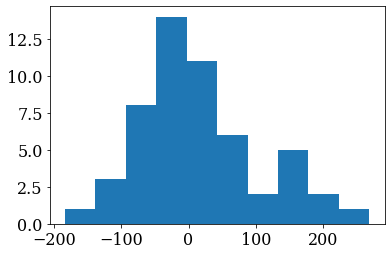

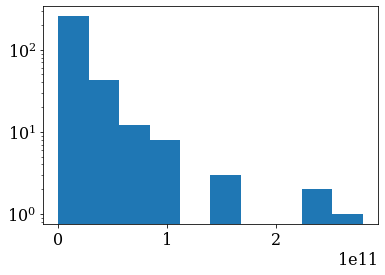

In [7]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

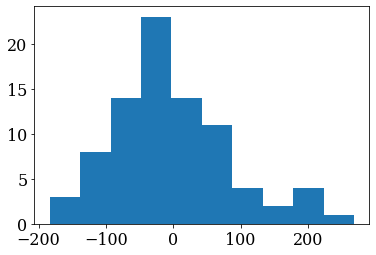

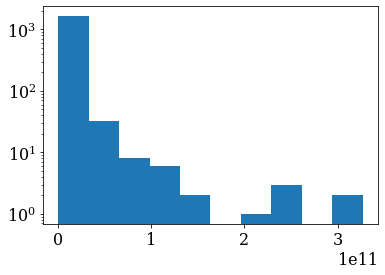

In [8]:
gas=ct.Solution('pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()

# Generate ODE file for AUTO

In [108]:
imp.reload(rmtchem)

<module 'rmtchem' from '/Users/zack/Documents/rmtchem/rmtchem.py'>

0.400574	
saddle-node bifurcation! 40.057394361496584
5017 2


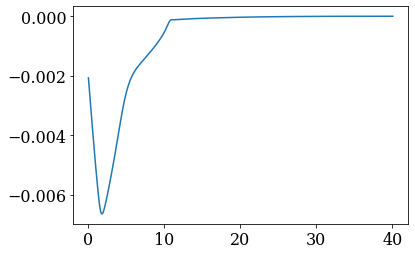

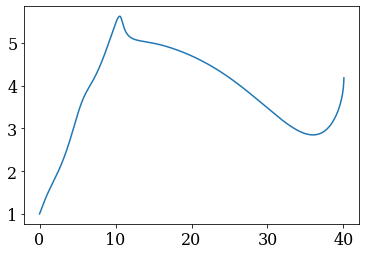

In [154]:
imp.reload(rmtchem)
n=64
nr=int(0.3*n*np.log(n))
nd=int(0.1*n)
na=0
seed=9
np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
steps=10000
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)

r=np.linalg.matrix_rank(adj.toarray()[np.ix_(lcc,lcc)])
if(r==n):

    Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,steps,True, False)
    print(len(Xs),bif)
    plt.plot(epsilons,np.max(np.real(evals),axis=1))
    plt.show()
    plt.plot(epsilons,Xs[:,0])
    plt.show()

    file=open('rmtchem.ode','w')
    for i in range(n):
        print('X[%i]\'=ep*D[%i]-E[%i]*X[%i]'%(i,i,i,i),end='',file=file)
        for j in range(2*nr):
            if((eta[j,i]-nu[j,i])!=0):
                print('+(%i)*%f'%(eta[j,i]-nu[j,i],k[j]),end='',file=file)
                inds=np.where(nu[j]>0)[0]
                for l in inds:
                    print('*X[%i]^(%i)'%(l,nu[j,l]),end='',file=file)
        print('\n',end='',file=file)

    for i in range(n):
        print('init X[%i]=%f'%(i,np.exp(-G)[i]),file=file)

    print('par ep=1',file=file)
    for i in range(n):
        print('par D[%i]=%f'%(i,XD1[i]),file=file)    
        print('par E[%i]=%f'%(i,XD2[i]),file=file)

    print('@ XP=T,YP=X0,XLO=0,XHI=1000,YLO=0,YHI=10',file=file)
    print('@ meth=cvode,dt=0.01,total=1000,nout=1000',file=file)
    print('@ NTST=100, NMAX=1000000, NPR=1000, DSMIN=1e-3, DSMAX=1e0, DS=1e-1, PARMIN=1.0, PARMAX=100',file=file)
    print('@ EPSU=1e-6, EPSL=1e-6, EPSS=1e-6, ITMX=10, ITNW=10, NWTN=20',file=file)
    print('@ NORMMAX=1e10, AUTOXMIN=0.0, AUTOXMAX=100, AUTOYMIN=0, AUTOYMAX=%f, AUTOVAR=X0_bar'%(2*np.max(Xs[:,0])),file=file)
    print('@ runnow=1, bound=100000',file=file)
    print('done',file=file)

    file.close()

40.057394361496584 40.0581441974359 31247626.914099395


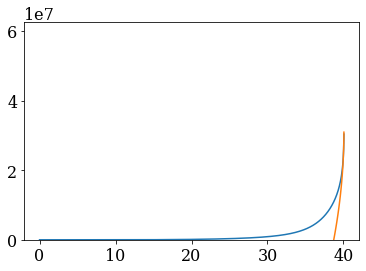

In [159]:
from scipy.optimize import leastsq
num=10
a=(np.linalg.norm(Xs[-1])-np.linalg.norm(Xs[-num]) )/(epsilons[-1]-epsilons[-num])
b=0.5*((np.linalg.norm(Xs[-1])+np.linalg.norm(Xs[-num]) )-a*(epsilons[-1]+epsilons[-num]))
sol=leastsq(lambda x: x[0]+x[1]*np.linalg.norm(Xs[-num:],axis=1) +x[2]*np.linalg.norm(Xs[-num:],axis=1)**2-epsilons[len(Xs)-num:len(Xs)],[b,a,0])
print(epsilons[len(Xs)-1],sol[0][0]-sol[0][1]**2/(4*sol[0][2]),-sol[0][1]/(2*sol[0][2]))
vals=-sol[0][1]/(2*sol[0][2])*np.arange(100)/100
# plt.xlim(0,10)
plt.ylim(0,-2*sol[0][1]/(2*sol[0][2]))
plt.plot(epsilons[:len(Xs)],np.linalg.norm(Xs,axis=1))
plt.plot(sol[0][0]+sol[0][1]*vals+sol[0][2]*vals**2,vals)
plt.show()